# Process
In this notebook, I will analyse the results of the recommendation.

## A. Import Libraries

In [1]:
import warnings
import pickle as pkl
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
#from run_algorithms import train_algorithms, train_algorithms_kf, prepare_dataset, prepare_dataset_kf
from tqdm import tqdm
import time
pd.set_option("display.precision", 6)
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, NMF
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR
from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

/ufs/savvina/.local/lib/python3.8/site-packages/pandas/compat/_optional.py:149: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)


## B. Set Hyperparameters

In [2]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "book" # the item column
my_seed = 0 # random_seed
top_fraction_items = 0.2 # the limit for an item to be considered popular
top_fraction_users = 0.2# the limit for a user to be considered High Mainstriminess
split_by = "pop_fraq" # sort users by fraction of popular items (pop_fraq) or by average popularity in profile (pop_item_fraq)
rd.seed(my_seed)
np.random.seed(my_seed)

These additions will be useful so we can load and save the different files (plots and processed data) with clarity on the hyperparameters.

In [3]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_by=="pop_fraq") else "_sbpif")

## C. Read Files
Files to read:
1. df_item_dist: the popularity of every item both in profiles and in recommendations (For Surprise and Cornac)
2. exp_results & exp_metrics: the Cornac results & metrics
3. low_rec_gap_list etc: the GAP in recommendations for all algorithms per group (for Surprise and Cornac)
4. GAP_list: the GAP in profile per group
5. training_ids: the user training ids
6. low, med, high: the low, med and high users

In [4]:
raw_file_location = "data/raw/" # here are stored the raw data files
processed_file_location = "data/processed/" # here we store the processed data files

In [5]:
df_item_dist_Cornac = pd.read_csv(processed_file_location+recommendation_type+"/item_pop_dist"+addition_1+"_results.csv", index_col=0)
df_item_dist_Surprise = pd.read_csv(processed_file_location+recommendation_type+"/item_pop_dist"+addition_1+"_results_Surprise.csv", index_col=0)

In [6]:
df_item_dist_Cornac.head()

,count,Random,MostPop,UserKNN,MF,PMF,BPR,NMF,WMF,PF,NeuMF,VAECF
421,0.055049,11,6358,3612,102,154,6358,0,1087,1198,6358,3335
424,0.043567,7,6358,2102,103,387,6358,0,685,679,6358,2317
1365,0.031299,11,6358,1622,137,404,6358,0,514,605,6358,1766
1464,0.029569,8,6358,1181,128,500,6358,0,413,373,6358,1560
2836,0.028311,8,6358,714,27,81,6358,1,403,606,0,1456


In [7]:
df_item_dist_Surprise.head()

,count,Random,MostPopular,UserItemAvg,UserKNN,UserKNNAvg,NMF,SVD
421,0.055049,6,5357,65,65,65,65,65
424,0.043567,5,5357,60,60,60,59,60
1365,0.031299,6,5357,38,38,38,38,38
1464,0.029569,13,5357,44,43,44,44,44
2836,0.028311,8,5357,39,38,38,39,38


In [8]:
# Cornac results
with open(processed_file_location+recommendation_type+"/experiment_results_cornac"+addition_4+".pkl", "rb") as f:
    exp_results = pkl.load(f)
with open(processed_file_location+recommendation_type+"/experiment_metrics_cornac"+addition_4+".pkl", "rb") as f:
    exp_metrics = pkl.load(f)

In [9]:
# Lists for low,med,high, for both Surprise and Cornac
with open(processed_file_location+recommendation_type+"/low_rec_gap_list_cornac"+addition_4+".pkl", "rb") as f:
    low_rec_gap_list_Cornac = pkl.load(f)
with open(processed_file_location+recommendation_type+"/med_rec_gap_list_cornac"+addition_4+".pkl", "rb") as f:
    med_rec_gap_list_Cornac = pkl.load(f)
with open(processed_file_location+recommendation_type+"/high_rec_gap_list_cornac"+addition_4+".pkl", "rb") as f:
    high_rec_gap_list_Cornac = pkl.load(f)
    
with open(processed_file_location+recommendation_type+"/low_rec_gap_list_Surprise"+addition_4+".pkl", "rb") as f:
    low_rec_gap_list_Surprise = pkl.load(f)
with open(processed_file_location+recommendation_type+"/med_rec_gap_list_Surprise"+addition_4+".pkl", "rb") as f:
    med_rec_gap_list_Surprise = pkl.load(f)
with open(processed_file_location+recommendation_type+"/high_rec_gap_list_Surprise"+addition_4+".pkl", "rb") as f:
    high_rec_gap_list_Surprise = pkl.load(f)

In [11]:
with open(processed_file_location+recommendation_type+"/GAP_list"+addition_4+".pkl", "rb") as f:
    GAP_list = pkl.load(f)
low_GAP = GAP_list[0]
med_GAP = GAP_list[1]
high_GAP = GAP_list[2]

In [12]:
with open(processed_file_location+recommendation_type+"/training_user_ids"+addition_4+".pkl", "rb") as f:
    training_ids = pkl.load(f)

In [13]:
with open(processed_file_location+recommendation_type+"/low_users"+addition_4+".csv", "rb") as f:
    low_users = pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/med_users"+addition_4+".csv", "rb") as f:
    med_users =  pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/high_users"+addition_4+".csv", "rb") as f:
    high_users =  pd.read_csv(f,  index_col=0)

In [20]:
[sum(df_item_dist_Surprise[col]) for col in df_item_dist_Surprise.columns]

[13.927650204466131, 53570, 53570, 16625, 16625, 16625, 16625, 16625]

## D. Analyze Results

In [12]:
algo_names = ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']

### D.1. Profile Popularity vs Recommendation Popularity

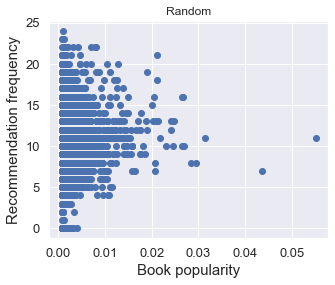

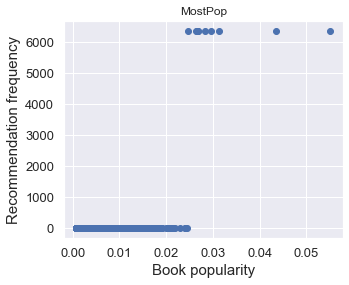

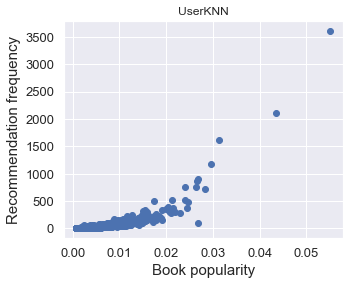

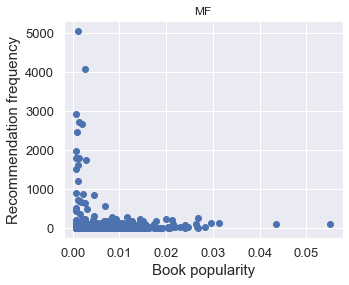

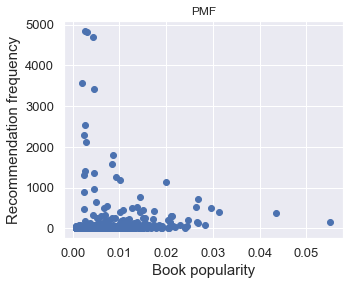

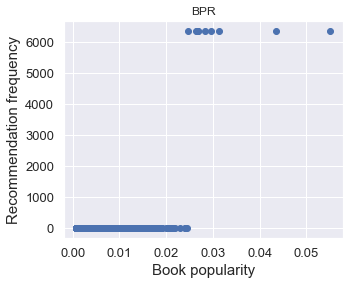

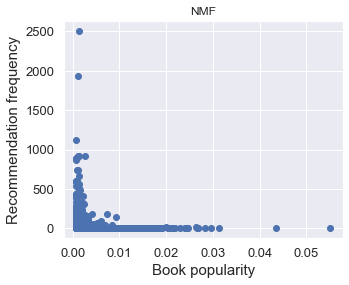

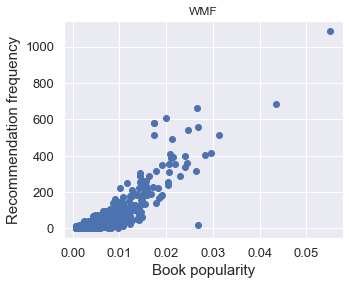

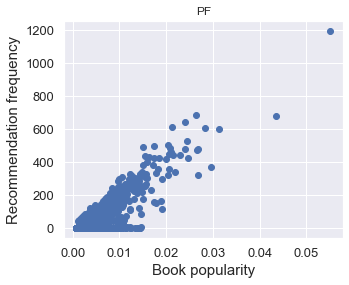

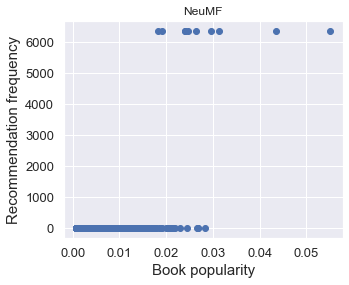

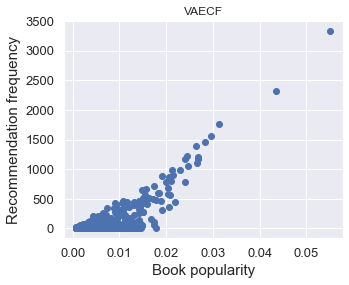

In [13]:
sns.set(rc = {'figure.figsize':(5,4)})
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist["count"]
    y = df_item_dist[algo_names[i]]

    plt.plot(x, y, 'o')
    plt.title(algo_names[i])
    plt.xlabel('Book popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')

### D.2. DGAP per group

In [14]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((med_rec_gap_list[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_GAP) / high_GAP * 100)

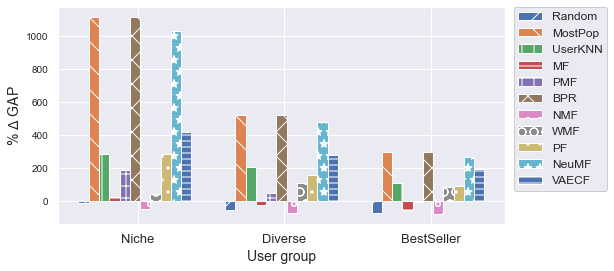

In [15]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]
bars5 = [low_gap_vals[4], medium_gap_vals[4], high_gap_vals[4]]
bars6 = [low_gap_vals[5], medium_gap_vals[5], high_gap_vals[5]]
bars7 = [low_gap_vals[6], medium_gap_vals[6], high_gap_vals[6]]
bars8 = [low_gap_vals[7], medium_gap_vals[7], high_gap_vals[7]]
bars9 = [low_gap_vals[8], medium_gap_vals[8], high_gap_vals[8]]
bars10 = [low_gap_vals[9], medium_gap_vals[9], high_gap_vals[9]]
bars11 = [low_gap_vals[10], medium_gap_vals[10], high_gap_vals[10]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
# r12 = [x + barWidth for x in r11]
# r13 = [x + barWidth for x in r12]

# ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserKNN', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='MF', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='PMF', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='BPR', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='NMF', hatch=patterns[6])
plt.bar(r8, bars8, width=barWidth, label='WMF', hatch=patterns[7])
plt.bar(r9, bars9, width=barWidth, label='PF', hatch=patterns[8])
plt.bar(r10, bars10, width=barWidth, label='NeuMF', hatch=patterns[9])
plt.bar(r11, bars11, width=barWidth, label='VAECF', hatch=patterns[10])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['Niche', 'Diverse', 'BestSeller'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()
#plt.savefig('gap_analysis.pdf', dpi=300, bbox_inches='tight')

### D3. Different user groups and metrics

In [16]:
print("User groups evaluation is started ...")

niche_users = list()
divers_users = list()
focused_users = list()

metric_group_results = defaultdict(list)
metric_group_results['MAE'] = list()
metric_group_results['Precision@10'] = list()
metric_group_results['Recall@10'] = list()
metric_group_results['NDCG@10'] = list()

ttest_group_results = defaultdict(list)
ttest_group_results['MAE'] = list()
ttest_group_results['Precision@10'] = list()
ttest_group_results['Recall@10'] = list()
ttest_group_results['NDCG@10'] = list()

for eachresult in exp_results:
    print("> " + eachresult.model_name)
    user_results = eachresult.metric_user_results # <- this is a dictionary
    for metric in exp_metrics:
        for user_idx, user_performance in user_results[metric.name].items():
            user_id = int(training_ids[user_idx])
            if user_id in low_users.index:
                niche_users.append(user_performance)
            elif user_id in med_users.index:
                divers_users.append(user_performance)
            elif user_id in high_users.index:
                focused_users.append(user_performance)
            else:
                print("Oops! We could not find a user!")

        print(metric.name + ": " + str(round(np.mean(niche_users), 4)) + "," + str(round(np.mean(divers_users), 4)) + "," + str(round(np.mean(focused_users), 4)))
        if metric.name in metric_group_results.keys():
            metric_group_results[metric.name].append((round(np.mean(niche_users), 4),
                                                round(np.mean(divers_users), 4),
                                                round(np.mean(focused_users), 4)))
      
            ttest_group_results[metric.name].append((round(stats.ttest_ind(niche_users, divers_users)[1], 8),
                                               round(stats.ttest_ind(niche_users, focused_users)[1], 8),
                                              round(stats.ttest_ind(divers_users, focused_users)[1], 8)))

        print(stats.ttest_ind(niche_users, focused_users))
        print(len(niche_users)+len(divers_users)+len(focused_users))
        niche_users.clear()
        divers_users.clear()
        focused_users.clear()
    print()

User groups evaluation is started ...
> MostPop
MAE: 2.7983,2.49,2.2781
Ttest_indResult(statistic=7.8214452174575255, pvalue=8.244333974448012e-15)
5394
MSE: 11.7842,9.8558,8.5366
Ttest_indResult(statistic=7.27129283195088, pvalue=5.020838755086015e-13)
5394
RMSE: 3.0618,2.7936,2.4842
Ttest_indResult(statistic=8.512792591763166, pvalue=3.2053811068502657e-17)
5394
AUC: 0.4538,0.651,0.8377
Ttest_indResult(statistic=-39.391517323338114, pvalue=6.941486194729806e-254)
5394
MAP: 0.0031,0.0138,0.0326
Ttest_indResult(statistic=-9.432389702924317, pvalue=1.0345787727699971e-20)
5394
MRR: 0.0074,0.0378,0.0642
Ttest_indResult(statistic=-9.719354865748116, pvalue=7.238843874641206e-22)
5394
Precision@5: 0.0017,0.0097,0.0177
Ttest_indResult(statistic=-8.151428061433256, pvalue=6.150055089338218e-16)
5394
Precision@10: 0.0014,0.0084,0.0131
Ttest_indResult(statistic=-9.553402397929402, pvalue=3.399689708513165e-21)
5394
Precision@20: 0.0012,0.0071,0.0103
Ttest_indResult(statistic=-11.65150739773167

MSE: 7.1612,6.5993,6.358
Ttest_indResult(statistic=3.2575392834079056, pvalue=0.0011419581683344586)
5394
RMSE: 2.4422,2.3684,2.2909
Ttest_indResult(statistic=3.2090987418624066, pvalue=0.00135183732087089)
5394
AUC: 0.5025,0.5266,0.5495
Ttest_indResult(statistic=-4.939441605022184, pvalue=8.461051632838498e-07)
5394
MAP: 0.0015,0.0016,0.0011
Ttest_indResult(statistic=1.576993233015676, pvalue=0.11494951395445724)
5394
MRR: 0.0029,0.0034,0.0016
Ttest_indResult(statistic=2.110994067162646, pvalue=0.034892148063919305)
5394
Precision@5: 0.0002,0.0004,0.0
Ttest_indResult(statistic=0.9889817556104619, pvalue=0.3227873748501754)
5394
Precision@10: 0.0005,0.0004,0.0001
Ttest_indResult(statistic=1.6085188668950494, pvalue=0.10787371271072008)
5394
Precision@20: 0.0006,0.0004,0.0001
Ttest_indResult(statistic=2.2911134051634514, pvalue=0.0220566665932215)
5394
Precision@50: 0.0006,0.0004,0.0002
Ttest_indResult(statistic=3.006861945464708, pvalue=0.0026712823196677012)
5394
Recall@5: 0.0005,0.00

RMSE: 6.8595,6.838,6.8384
Ttest_indResult(statistic=0.3218663805854822, pvalue=0.7475863441840944)
5394
AUC: 0.7242,0.7682,0.8727
Ttest_indResult(statistic=-18.490690668121673, pvalue=8.73255608035225e-71)
5394
MAP: 0.0076,0.0197,0.0452
Ttest_indResult(statistic=-10.690068646119798, pvalue=5.308883016068003e-26)
5394
MRR: 0.0138,0.0476,0.0796
Ttest_indResult(statistic=-11.051934298375587, pvalue=1.245072564680005e-27)
5394
Precision@5: 0.0021,0.0134,0.0241
Ttest_indResult(statistic=-9.474509827712556, pvalue=7.033349144766836e-21)
5394
Precision@10: 0.0036,0.0123,0.0207
Ttest_indResult(statistic=-10.8662323475185, pvalue=8.659948985857331e-27)
5394
Precision@20: 0.0035,0.0103,0.0166
Ttest_indResult(statistic=-12.556746141375616, pvalue=6.556154711594084e-35)
5394
Precision@50: 0.0029,0.008,0.0112
Ttest_indResult(statistic=-14.213891204893084, pvalue=7.989090236744163e-44)
5394
Recall@5: 0.0031,0.0191,0.0522
Ttest_indResult(statistic=-8.656596932675885, pvalue=9.578237107403767e-18)
539

In [17]:
len(low_users)*0.8

1016.8000000000001

In [18]:
6400*0.8

5120.0

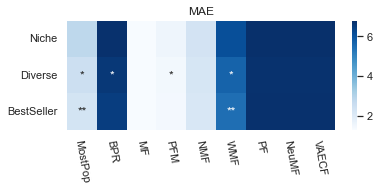

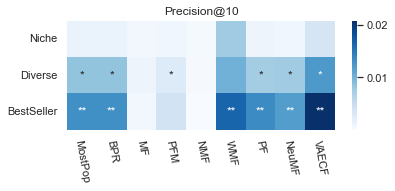

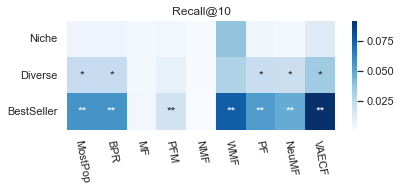

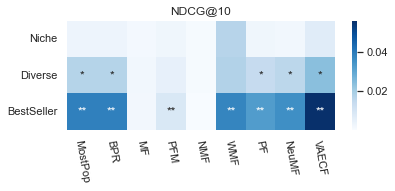

In [26]:
sns.set(rc = {'figure.figsize':(6,2)})

for metric in ['MAE', 'Precision@10', 'Recall@10', 'NDCG@10']:
    data = [[], [], []]
    labels = [['', '', '', '', '', '', '', '', ''], [], []]

    for item in metric_group_results[metric]:
        # print(item)
        data[0].append(item[0])
        data[1].append(item[1])
        data[2].append(item[2])


    for item in ttest_group_results[metric]:
        if item[0] < 0.005:
            labels[1].append('*')
        else:
            labels[1].append('')
        if item[1] < 0.005 and item[2] < 0.005:
            labels[2].append('**')
        else:
            labels[2].append('')

    fig, ax = plt.subplots()
    ax.set_title(metric)
    ax = sns.heatmap(data, annot=labels, fmt = '', cmap="Blues")
    ax.set_xticklabels(['MostPop', 'BPR', 'MF', 'PFM', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF'])
    ax.set_yticklabels(['Niche', 'Diverse', 'BestSeller'])
    ax.tick_params(axis='x', rotation=280)
    ax.tick_params(axis='y', rotation=0)
    #plt.savefig(f'{metric}_metric_analysis.pdf', dpi=300, bbox_inches='tight')